# E3: Test Transforms on IQ2 Debate Corpus

#### ConversationBalance:
* The host should have a high balance score at the beginning and end when introducing/closing out the debate, but low balance during the rest of the conversation because he does not speak.
* The moderator should have a fairly low balance throughout the conversation, since he is probably mostly calling on different people to answer debate questions.
* The audience should have lower balance in general since they are likely asking questions which have long follow-ups.
* The debaters may have higher balance in the beginning if they are introducing themselves


#### Vocabulary Overlap
* Debaters with the same position (for or against) will have increasingly similar vocabulary as the debate progresses
* Debaters with different positions will have the same or smaller overlap as the debate progresses

#### NLTK Sentiment Analysis
We are using this as a baseline to compare our other metrics to. We hypothesize that the sentiment may decline through a conversation if it is a heated debate.

### Import dependancies and load corpus

In [1]:
import os
os.chdir("../../") # import convokit
from convokit import Corpus, User, Utterance
os.chdir("datasets/iq2_corpus") # then come back for switchboard
import convokit
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

In [2]:
corpus = Corpus(filename="./corpus")

### Apply all the transformers

We apply the ConversationBalance, VocabOverlap, and VaderSentiment transformers. The DAMSLScores transformer does not apply in this case because the DAMSL tags are unique to the Switchboard corpus.

In [3]:
# Apply the ConversationBalance transformer
cb = convokit.ConversationBalance()
cb.transform(corpus)

In [4]:
# Apply the VocabOverlap transformer
vo = convokit.VocabOverlap()
vo.transform(corpus)

In [5]:
# Apply the VaderSentiment transformer
fi = convokit.VaderSentiment()
fi.transform(corpus)

### Measure 1: Conversation Balance

In this section, we will look at the conversation balance. Conversation balance is defined for each user pair as the number of tokens User A spoke over the sum of tokens that User A and User B spoke. Balance is also defined on a statement level. A statement is a group of consecutive utterances spoken by the same user (in the Switchboard corpus, statements were broken into as many as 30 consecutive utterances by the same user). Statement balance is the number of tokens spoken in the current statement over the sum of tokens in the current and next statement.

Let's see what the conversation-level balance looks like.

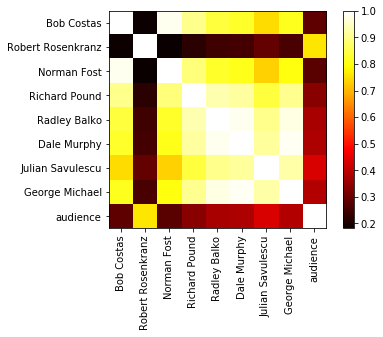

For a perfectly balanced conversation, we would expect low color variation in the plot. Brighter squares (higher scores)
indicate that the person in the row spoke a lot and got a shorter response, while darker squares indicatethat the user said something short and got longer responses.
As expected, the outliers in this plot are:
        1) The host (Robert Rosenkranz), who speaks rarely and only introduces/closes the debate
        2) The audience, which also speaks relatively little during the debate and gets longer responses
We also note that the moderator, Bob Costas has relatively high balance, which is surprising. This means he tends to ask 
longer questions than the responses he receives.


In [6]:
# There are many speakers in the IQ2 conversations, not just two as in switchboard conversations
# We can plot the balance in the conversation as a heatmap. Note the diagonal values should all be 0.5

c = corpus.conversations['0']
balance = c.meta['conversation_balance']
users = c._usernames  

plt.imshow(balance, cmap='hot')
plt.title('')
plt.xticks(np.arange(len(users)),users, rotation=90)
plt.yticks(np.arange(len(users)), users)
plt.ylim(len(users)-0.5, -0.5)
plt.colorbar()
plt.show()
        
print('For a perfectly balanced conversation, we would expect low color variation in the plot. Brighter squares (higher \
scores)\nindicate that the person in the row spoke a lot and got a shorter response, while darker squares indicate\
that the user said something short and got longer responses.')
print('As expected, the outliers in this plot are:\n\
        1) The host (Robert Rosenkranz), who speaks rarely and only introduces/closes the debate\n\
        2) The audience, which also speaks relatively little during the debate and gets longer responses\n\
We also note that the moderator, Bob Costas has relatively high balance, which is surprising. This means he \
tends to ask \nlonger questions than the responses he receives.')

Let's take a quick look at one conversation...

In [7]:
# Looking at just one conversation:
print('Users in this conversation:', corpus.conversations['0']._usernames)

print('\nHere are the IDs for the first 5 utterances of the conversation, and the balance from',
     '\nthis utterance to the next:')
utt_list = corpus.conversations['0']._utterance_ids
for i, u in enumerate(utt_list):
    if 'statement_balance' in corpus.utterances[u].meta:
        name = corpus.utterances[u].user.name
        score = corpus.utterances[u].meta['statement_balance']
        print(u, name, '\t', score)
        
    if i > 4:
        break

print('It looks like the mod, Bob Costas, says many short phrases which are followed up with longer responses by debaters')

Users in this conversation: ['Bob Costas', 'Robert Rosenkranz', 'Norman Fost', 'Richard Pound', 'Radley Balko', 'Dale Murphy', 'Julian Savulescu', 'George Michael', 'audience']

Here are the IDs for the first 5 utterances of the conversation, and the balance from 
this utterance to the next:
0 Bob Costas 	 0.129979035639413
1 Robert Rosenkranz 	 0.9685124864277959
2 Bob Costas 	 0.5520046484601976
3 Norman Fost 	 0.009584664536741214
4 Bob Costas 	 0.025477707006369428
5 Norman Fost 	 0.008565310492505354
It looks like the mod, Bob Costas, says many short phrases which are followed up with longer responses by debaters


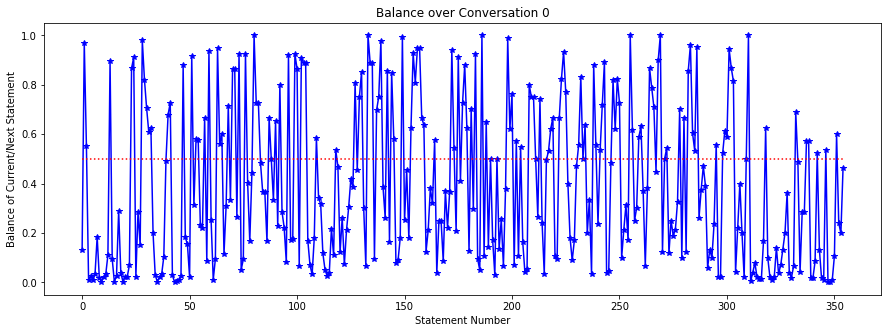

In [8]:
utt_list = corpus.conversations['0']._utterance_ids
statement_ids = []
statement_balances = []

for u in utt_list:
    if 'statement_balance' in corpus.utterances[u].meta:
        statement_ids.append(u)
        statement_balances.append(corpus.utterances[u].meta['statement_balance'])
    
plt.figure(figsize=(15,5))
plt.plot(range(len(statement_balances)), statement_balances, 'b*-')
plt.plot(range(len(statement_balances)), 0.5*np.ones(len(statement_balances)), 'r:')
plt.title('Balance over Conversation 0')
plt.xlabel('Statement Number')
plt.ylabel('Balance of Current/Next Statement')
plt.show()

Based on this plot, it looks like the beginning and end of the conversation have a lot more polarized scores, perhaps from the moderator opening up and closing out the debate. Let's compare the beginning of the debate to the rest.

In [9]:
beg_balance = []
rest_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split = round(0.2*len(statement_balances))

    beginning = statement_balances[:split]
    rest = statement_balances[split:]
    assert(len(beginning)+len(rest) == len(statement_balances))
    beg_balance.append(sum(beginning)/len(beginning))
    rest_balance.append(sum(rest)/len(rest))
        
print('The average balance of the first 20% of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the rest of the conversation is:', sum(rest_balance)/len(rest_balance))

The average balance of the first 20% of the conversation is: 0.34861755781418974
The average balance of the rest of the conversation is: 0.38446843331827474


It doesn't seem as though there is a difference in average balance from the beginning 10% to the rest of the conversation. What if we compare the beginning, middle, and end?

In [10]:
beg_balance = []
mid_balance = []
end_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split1 = round(0.1*len(statement_balances))
    split2 = round(0.9*len(statement_balances))

    beginning = statement_balances[:split1]
    middle = statement_balances[split1:split2]
    end = statement_balances[split2:]
    
    assert(len(beginning)+len(middle)+len(end) == len(statement_balances))
    
    beg_balance.append(sum(beginning)/len(beginning))
    mid_balance.append(sum(middle)/len(middle))
    end_balance.append(sum(end)/len(end))
        
print('The average balance of the beginning of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the middle of the conversation is:', sum(mid_balance)/len(mid_balance))
print('The average balance of the end of the conversation is:', sum(end_balance)/len(end_balance))

The average balance of the beginning of the conversation is: 0.34737340073398876
The average balance of the middle of the conversation is: 0.3870589796309751
The average balance of the end of the conversation is: 0.32905168457211104


It looks as though in the last 10% of the debate, there is slightly lower balance (i.e. people tend to speak less and get longer responses) than the middle or beginning.

### Measure 2: Overlapping use of vocabulary

We hypothesize that speakers with the same position are likely to increase their vocab overlap as the conversation progresses, while people with different positions are likely to have their vocab overlap decrease or remain the same.

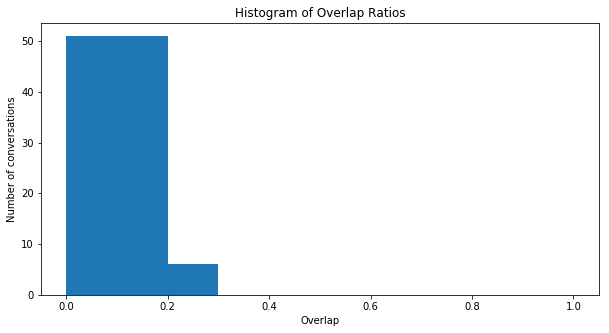

Mean = 0.105698 / StDev = 0.048702


In [11]:
overlaps = []
for i, convo in enumerate(corpus.iter_conversations()):
    
    overlaps.append(convo.meta['vocabulary_overlap']['ratio'])

plt.figure(figsize=(10,5))
plt.hist(overlaps, bins = np.linspace(0,1,num=11))
plt.title('Histogram of Overlap Ratios')
plt.xlabel('Overlap')
plt.ylabel('Number of conversations')
plt.show()

print('Mean = %f / StDev = %f' % (np.mean(overlaps), np.std(overlaps)))

In [12]:
# Observe what words are overlapping across different users
for i, convo in enumerate(corpus.iter_conversations()):
    
    vo = convo.meta['vocabulary_overlap']
    print('+ Overlapping words in convo %s: %s\n' % (convo.id, vo['vocab']))
    if i == 2:
        break

+ Overlapping words in convo 0: {'whether', 'foundation', 'drugs', 'would', 'say', 'baseball', 'think', 'steroids', 'us', 'thank', 'sports', 'squared', 'performance', 'use', 'competitive', 'rosenkranz', 'well', 'debate', 'rules', 'want', 'enhancing', 'intelligence', 'make'}

+ Overlapping words in convo 356: {'going', 'raise', 'would', 'point', 'get', 'government', 'way', 'tax', 'percent', 'put', 'one', 'rich', 'taxes', 'think', 'go', 'really', 'well', 'top'}

+ Overlapping words in convo 671: {'speech', 'must', 'free', 'see', 'license', 'include', 'offend', 'like', 'freedom', 'know', 'think', 'expression', 'well'}



Over all of the debates, it seems that there is relatively little overlap in vocabulary amongst all of the participants.

Let's see how the overlap changes over time. The first plot below is the overlap over time. The second plot shows the change of this plot between utterances. In the second plot, we can see that most increases in vocab overlap are concentrated towards the end of the conversation.

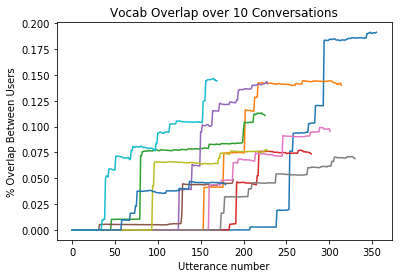

In [13]:
# Utterance-level overlap is the vocab overlap from the start until that
# utterance in the conversation (strictly increasing). 

for i, c in enumerate(corpus.conversations):
    utt_list = corpus.conversations[c]._utterance_ids

    overlap = []
    for u in utt_list:
        overlap.append(corpus.utterances[u].meta['vocabulary_overlap']['ratio'])
        
    plt.plot(np.arange(len(overlap)), overlap)
    plt.title('Vocab Overlap over 10 Conversations')
    plt.xlabel('Utterance number')
    plt.ylabel('% Overlap Between Users')
    
    if i == 10:
        break

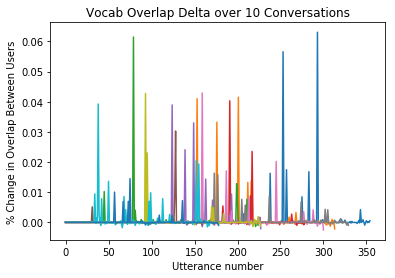

In [14]:
# Utterance-level overlap is the vocab overlap from the start until that
# utterance in the conversation 

for i, c in enumerate(corpus.conversations):
    utt_list = corpus.conversations[c]._utterance_ids

    overlap = []
    for u in utt_list:
        overlap.append(corpus.utterances[u].meta['vocabulary_overlap']['ratio'])
        
    change_in_overlap = []
    for j in range(1, len(overlap)):
        change_in_overlap.append(overlap[j] - overlap[j-1])
        
#     plt.figure()
    plt.plot(np.arange(len(change_in_overlap)), change_in_overlap)
    plt.title('Vocab Overlap Delta over 10 Conversations')
    plt.xlabel('Utterance number')
    plt.ylabel('% Change in Overlap Between Users')
    
    if i == 10:
        break

Let's compare the first 20% of the conversation to the rest (10% was not enough to capture overlap because one person can talk through the first 10% of the conversation)

In [15]:
# Utterance-level overlap is the vocab overlap from the start until that
# utterance in the conversation (strictly increasing). 
beg_scores_o = []
rest_scores_o = []
beg_scores_c = []
rest_scores_c = []
for i, c in enumerate(corpus.conversations):
    utt_list = corpus.conversations[c]._utterance_ids

    overlap = []
    for u in utt_list:
        overlap.append(corpus.utterances[u].meta['vocabulary_overlap']['ratio'])
        
    change_in_overlap = []
    for j in range(1, len(overlap)):
        change_in_overlap.append(overlap[j] - overlap[j-1])
        
    split = round(0.2*len(overlap))

    beg_o = overlap[:split]
    end_o = overlap[split:]
    beg_c = change_in_overlap[:split]
    end_c = change_in_overlap[split:]
    
    beg_scores_o.append(sum(beg_o)/len(beg_o))
    rest_scores_o.append(sum(end_o)/len(end_o))
    beg_scores_c.append(sum(beg_c)/len(beg_c))
    rest_scores_c.append(sum(end_c)/len(end_c))

beg_avg_o = sum(beg_scores_o)/len(beg_scores_o)
rest_avg_o = sum(rest_scores_o)/len(rest_scores_o)
beg_avg_c = sum(beg_scores_c)/len(beg_scores_c)
rest_avg_c = sum(rest_scores_c)/len(rest_scores_c)

print('Overlap in first 20%:\t', beg_avg_o)
print('Overlap in remaining 80%:\t', rest_avg_o)
print('Change in overlap in first 20%:\t', beg_avg_c)
print('Change in overlap in remaining 80%:\t',rest_avg_c)
print('We can see our vocabulary overlap increases throughout the conversations')

Overlap in first 20%:	 0.0023979109416665196
Overlap in remaining 80%:	 0.05619593749611657
Change in overlap in first 20%:	 0.00014628885467113492
Change in overlap in remaining 80%:	 0.0005470029014623697
We can see our vocabulary overlap increases throughout the conversations


#### Measure 3: Sentiment analysis for first impressions

As a baseline, we will look at NLTK's VADER sentiment analyzer applied to the IQ2 dataset. We will use the ```compound``` metric, which is NLTK's descriptor of how positive (+1) or negative (-1) the first 10% of a conversation is for each user.

Plotting some NLTK scores over 3 conversations...
Average score was 0.1598123595505618 for plot 0
Average score was 0.23490666666666657 for plot 1
Average score was 0.13381681415929209 for plot 2


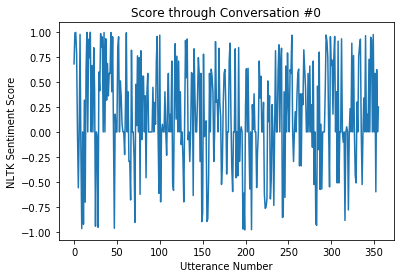

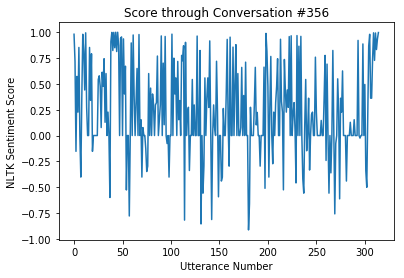

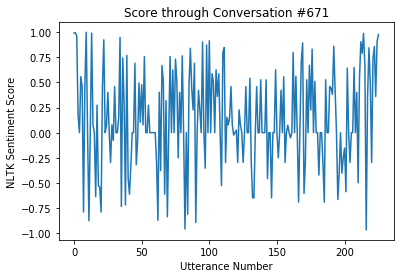

In [16]:
print('Plotting some NLTK scores over 3 conversations...')
for i, c in enumerate(corpus.conversations):
    utt_list = corpus.conversations[c]._utterance_ids

    utt_scores = []
    for u in utt_list:
        if 'polarity' in corpus.utterances[u].meta:
            utt_scores.append(corpus.utterances[u].meta['polarity']['compound'])
    
    plt.figure()
    plt.plot(np.arange(len(utt_scores)), utt_scores)
    plt.title('Score through Conversation #'+str(c))
    plt.xlabel('Utterance Number')
    plt.ylabel('NLTK Sentiment Score')
    print('Average score was', sum(utt_scores)/len(utt_scores), 'for plot', i)
    
    if i == 2:
        break

On average, what does the NLTK score look like for the beginning of the conversation versus the rest?

In [17]:
beg_scores = []
rest_scores = []
for i, c in enumerate(corpus.conversations):
    utt_list = corpus.conversations[c]._utterance_ids

    utt_scores = []
    for u in utt_list:
        if 'polarity' in corpus.utterances[u].meta:
            utt_scores.append(corpus.utterances[u].meta['polarity']['compound'])
    
    split = round(0.4*len(overlap))

    beg = overlap[:split]
    end = overlap[split:]
    
    beg_scores.append(sum(beg)/len(beg))
    rest_scores.append(sum(end)/len(end))

print('Below are the scores for the first 40% of the conversation versus\
the last 60% of the conversation, because compound scores \nwere all 0 for the \
first 30%')
print('Sentiment score for first 40%:', sum(beg_scores)/len(beg_scores))
print('Sentiment score for last 60%:', sum(rest_scores)/len(rest_scores))


Below are the scores for the first 40% of the conversation versusthe last 60% of the conversation, because compound scores 
were all 0 for the first 30%
Sentiment score for first 40%: 0.0006780518659076516
Sentiment score for last 60%: 0.08320138266913445


## Comparing NLTK Compound Score to Our Metrics

We would like to check our hypotheses at the beginning by comparing our metrics to the results from the NLTK Sentiment Analyzer, which we are using as a baseline metric. If the sentiment score and our metrics align, we would expect to see the points scattered around the line y=x.

#### Vader Sentiment vs. Conversation Balance

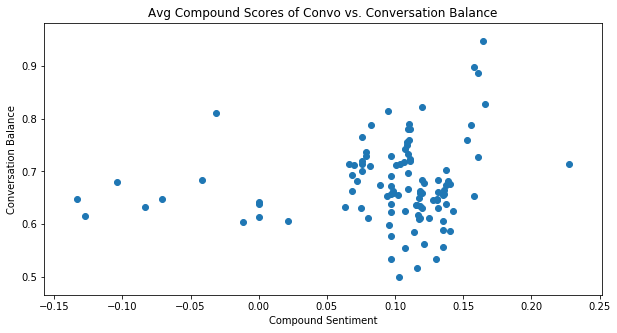

In [18]:
convoBalances = []
convoSentiment = []

for i, c in enumerate(corpus.conversations):
    balance = corpus.conversations[c].meta['conversation_balance']
    sentiment = corpus.conversations[c].meta['initial_sentiment']
    
    avg_balance = 0
    count = 0
    for x in range(len(balance[0])-1):
        for y in range(x):
            avg_balance += balance[x,y]
            count += 1
    avg_balance /= count
    
    avg_sentiment = 0
    for user in sentiment:
        avg_sentiment += sentiment[user]['compound']
    avg_sentiment /= len(sentiment)
    
    convoBalances.append(avg_balance)
    convoSentiment.append(avg_sentiment)

plt.figure(figsize=(10,5))
plt.scatter(convoSentiment, convoBalances)
plt.title('Avg Compound Scores of Convo vs. Conversation Balance')
plt.xlabel('Compound Sentiment')
plt.ylabel('Conversation Balance')
plt.show()

It seems that our conversation balance score is generally higher than the NLTK score, and tends to give high balance even when sentiment is low.

#### Vader Sentiment vs. Vocab Overlap

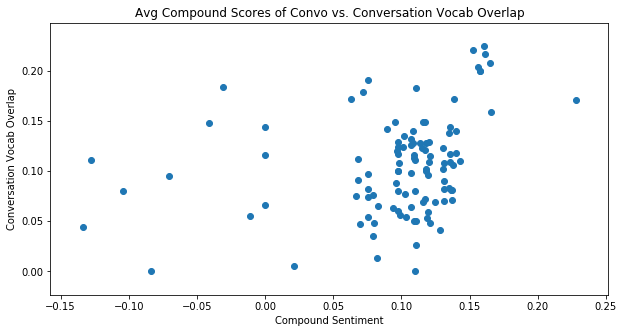

In [19]:
convoOverlap = []
convoSentiment = []

for i, c in enumerate(corpus.conversations):
    overlap = corpus.conversations[c].meta['vocabulary_overlap']['ratio']
    sentiment = corpus.conversations[c].meta['initial_sentiment']

    convoOverlap.append(overlap)
    
    avg_sentiment = 0
    for user in sentiment:
        avg_sentiment += sentiment[user]['compound']
    avg_sentiment /= len(sentiment)
    
    convoSentiment.append(avg_sentiment)

plt.figure(figsize=(10,5))
plt.scatter(convoSentiment, convoOverlap)
plt.title('Avg Compound Scores of Convo vs. Conversation Vocab Overlap')
plt.xlabel('Compound Sentiment')
plt.ylabel('Conversation Vocab Overlap')
plt.show()

It seems that our score for overlap is a relatively good indicator for positive sentiment, but there is still relatively high overlap for low-sentiment conversations.

## Checking our main hypothesis
Let's see if there's a difference between the first part of the debates and the rest using our metrics.

### Change of Sentiment within Conversations
This section compares the NLTK Vader Sentiment Analyser scores at the beginning of the conversation with the rest of the conversation and the overall conversation.

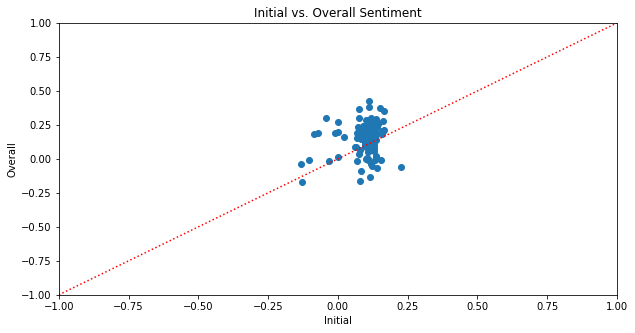

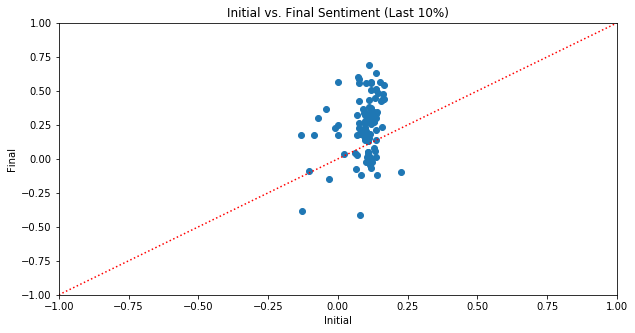

In [20]:
initialSentiments = []
overallSentiments = []
finalSentiments = []

for i, c in enumerate(corpus.conversations):
    # Get initial conversation sentiment (average of all users)
    init_sent_all_users = corpus.conversations[c].meta['initial_sentiment']
    init_sent = 0
    for user in init_sent_all_users:
        init_sent += init_sent_all_users[user]['compound']
    initialSentiments.append(init_sent/len(init_sent_all_users))
    
    # Get overall sentiment
    utt_list = corpus.conversations[c]._utterance_ids
    utt_scores = []
    for u in utt_list:
        if 'polarity' in corpus.utterances[u].meta:
            utt_scores.append(corpus.utterances[u].meta['polarity']['compound'])
    
    overallSentiments.append(sum(utt_scores)/len(utt_scores))
    
    split = int(0.1*len(utt_scores))
    end = utt_scores[-1*split:]
    finalSentiments.append(sum(end)/len(end))
    
    
plt.figure(figsize=(10,5))
plt.scatter(initialSentiments, overallSentiments)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Overall Sentiment')
plt.xlabel('Initial')
plt.ylabel('Overall')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(initialSentiments, finalSentiments)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Final Sentiment (Last 10%)')
plt.xlabel('Initial')
plt.ylabel('Final')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

### Change of Balanace within Conversations
This section compares the Conversation Balanace scores at the beginning of the conversation with the rest of the conversation and the overall conversation.

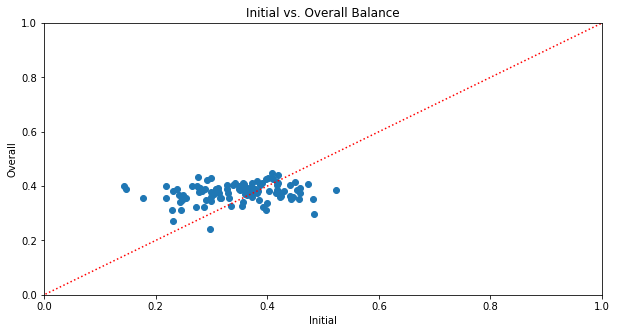

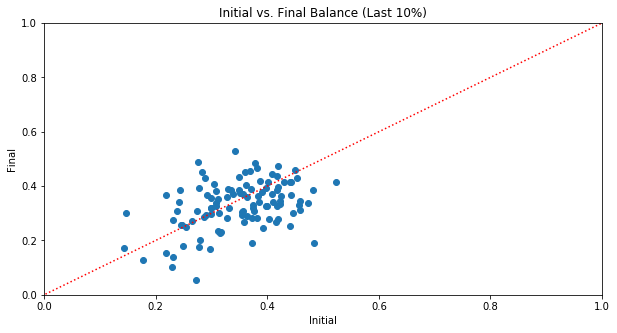

In [21]:
initialBalance = []
overallBalance = []
finalBalance = []

for i, c in enumerate(corpus.conversations):

    utt_list = corpus.conversations[c]._utterance_ids
    utt_scores = []
    for u in utt_list:
        try:
            utt_scores.append(corpus.utterances[u].meta['statement_balance'])
        except KeyError:
            continue
    
    split = int(0.1*len(utt_scores))
    beg = utt_scores[:split]
    end = utt_scores[-1*split:]
    
    initialBalance.append(sum(beg)/len(beg))
    finalBalance.append(sum(end)/len(end))
    overallBalance.append(sum(utt_scores)/len(utt_scores))
    
    
plt.figure(figsize=(10,5))
plt.scatter(initialBalance, overallBalance)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Overall Balance')
plt.xlabel('Initial')
plt.ylabel('Overall')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(initialBalance, finalBalance)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Final Balance (Last 10%)')
plt.xlabel('Initial')
plt.ylabel('Final')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

### Change of Vocab Overlap within Conversations
This section compares the Vocabulary Overlap scores at the beginning of the conversation with the rest of the conversation and the overall conversation.

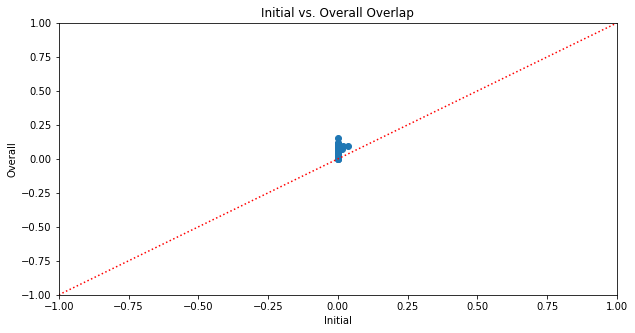

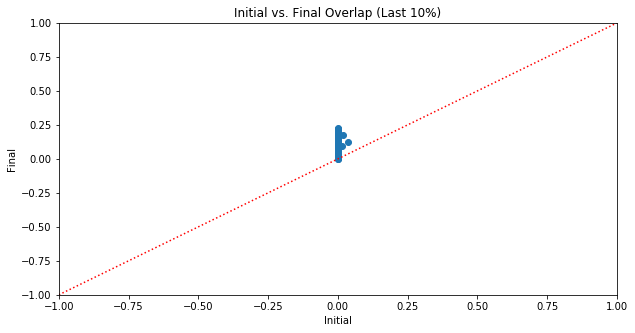

It seems that most of the conversations average out to be fairly little overlap.


In [22]:
initialOverlap = []
overallOverlap = []
finalOverlap = []

for i, c in enumerate(corpus.conversations):

    
    utt_list = corpus.conversations[c]._utterance_ids
    utt_scores = []
    for u in utt_list:
        try:
            utt_scores.append(corpus.utterances[u].meta['vocabulary_overlap']['ratio'])
        except KeyError:
            continue
    
    split = int(0.1*len(utt_scores))
    beg = utt_scores[:split]
    end = utt_scores[-1*split:]
    
    initialOverlap.append(sum(beg)/len(beg))
    finalOverlap.append(sum(end)/len(end))
    overallOverlap.append(sum(utt_scores)/len(utt_scores))
    
    
plt.figure(figsize=(10,5))
plt.scatter(initialOverlap, overallOverlap)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Overall Overlap')
plt.xlabel('Initial')
plt.ylabel('Overall')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(initialOverlap, finalOverlap)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Final Overlap (Last 10%)')
plt.xlabel('Initial')
plt.ylabel('Final')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()
print('It seems that most of the conversations average out to be fairly little overlap.')